In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal

class VisionModel(torch.nn.Module):
    def __init__(self,  channel_size, height, width, dim_z, lr, device):
        super(VisionModel, self).__init__()

        self.channel_size = channel_size
        self.height = height
        self.width = width
        self.dim_z = dim_z
        self.lr = lr
        self.device = device

        ## Input size : [batch, 3, 84, 84]
        ### Encoder
        
        self.conv1 = nn.Conv2d(in_channels=self.channel_size, out_channels=32,
                               kernel_size=4, stride=2, padding=0).to(device) # [32, 41, 41]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=5, stride=2, padding=2).to(device) # [32, 21, 21]
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=7, stride=7, padding=0).to(device) # [32, 3, 3]

        self.mu = nn.Linear(32 * 9, self.dim_z).to(device)
        self.log_std = nn.Linear(32 * 9, self.dim_z).to(device)

        self.recons = nn.Linear(dim_z, 256).to(device)


        ### Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                          kernel_size=3, stride=1, padding=0).to(device)  # [128, 3, 3]
        self.t_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                          kernel_size=7, stride=7, padding=0).to(device)  # [64, 21, 21]
        self.t_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32,
                                          kernel_size=5, stride=2, padding=2).to(device)  # [32, 41, 41]
        self.t_conv4 = nn.ConvTranspose2d(in_channels=32, out_channels= self.channel_size,
                                          kernel_size=4, stride=2, padding=0).to(device)  # [3, 84, 84]

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def encode(self, x):
        assert len(x.shape) == 4

        x = F.celu(self.conv1(x))
        x = F.celu(self.conv2(x))
        x = F.celu(self.conv3(x))

        x = x.view(-1, 32 * 9)

        mu = self.mu(x)
        sigma = torch.exp(self.log_std(x))

        return mu, sigma

    def reparameterization(self, mu, sigma):
        temp_normal = Normal(mu, sigma)

        return temp_normal.rsample()  # [batch, 16]

    def decode(self, z):
        x = F.celu(self.recons(z))  # [batch, 256]

        x = x.view(-1, 256, 1, 1)

        x = F.celu(self.t_conv1(x))
        x = F.celu(self.t_conv2(x))
        x = F.celu(self.t_conv3(x))
        x = torch.sigmoid(self.t_conv4(x))

        return x

    def train(self, batch):
        assert len(batch.shape) == 4

        mus, sigmas = self.encode(batch)
        zs = self.reparameterization(mus, sigmas)

        recons = self.decode(zs)

        reconstruction_error = F.binary_cross_entropy(recons, batch, reduction="sum") / batch.shape[0]

        var = sigmas ** 2
        mu_2 = mus ** 2

        regularization_error = torch.mean(torch.sum(-0.5 * (1 + torch.log(var) - mu_2 - var), dim=1, keepdim=False))

        loss = reconstruction_error + regularization_error

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.parameters(), 1.0)
        self.optimizer.step()

        return reconstruction_error.detach().cpu().numpy(), regularization_error.detach().cpu().numpy(), loss.detach().cpu().numpy()

In [2]:
vm = VisionModel(3, 84, 84, 64, 1e-3, torch.device("cuda"))

In [4]:
t = torch.randn([1,3,84,84]).to(torch.device("cuda"))

In [5]:
z = vm.encode(t)

In [8]:
z = vm.reparameterization(*z)

In [10]:
im = vm.decode(z)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [20]:
np.moveaxis(im[0].detach().cpu().numpy(),[0,1,2],[2,0,1]).shape

(84, 84, 3)

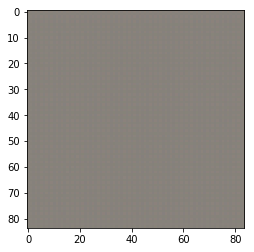

In [21]:
plt.imshow(np.moveaxis(im[0].detach().cpu().numpy(),[0,1,2],[2,0,1]))